In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,label_binarize
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay,confusion_matrix,roc_auc_score, roc_curve, auc
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict


In [2]:
df=pd.read_csv("HR_comma_sep.csv")
df.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


## 1. Perform data quality checks by checking for missing values, if any.

In [4]:
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

### Conclusion- There are no null values

In [6]:
df.shape

(14999, 10)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [8]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [9]:
# check for any negative values
((df.select_dtypes(include=np.number))<0).sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
dtype: int64

### Conclusion- There are no negative values

## 2. Understand what factors contributed most to employee turnover at EDA.
## 2.1. Draw a heatmap of the correlation matrix between all numerical features or columns in the data.

<Axes: >

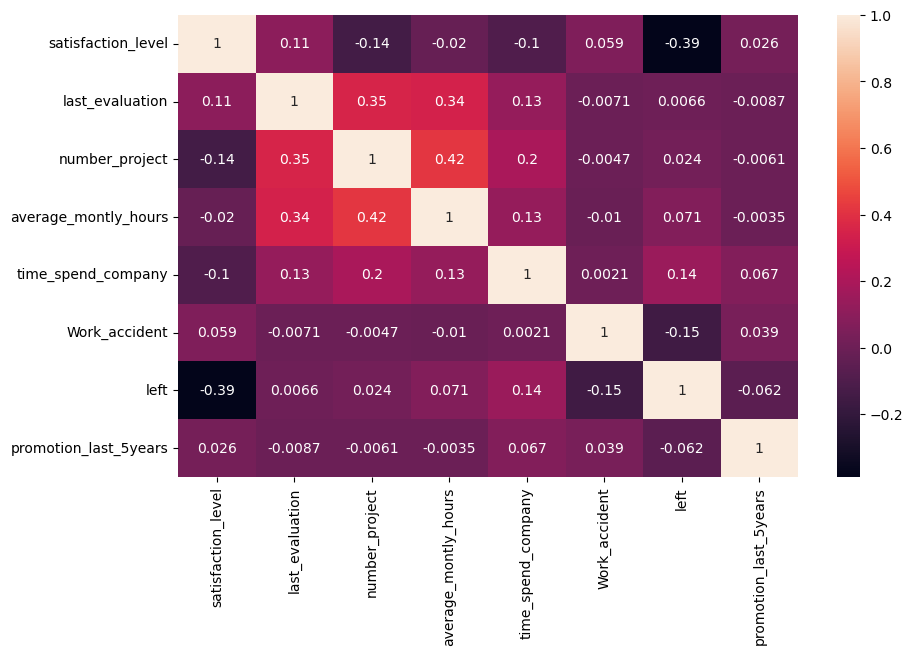

In [12]:
plt.figure(figsize=(10,6))
sns.heatmap(data=(df.select_dtypes(include=np.number)).corr(),annot=True)

## Key Observations from the Heatmap

### 1. Satisfaction Level:

#### Negatively correlated with left (-0.39):

Employees with lower satisfaction levels are more likely to leave the organization.

#### Weak negative correlation with number_project (-0.14) and time_spend_company (-0.1):

Suggests employees working on more projects or spending more time at the company may have slightly lower satisfaction.

### 2. Last Evaluation:

#### Positively correlated with number_project (0.35) and average_monthly_hours (0.34):

Higher evaluations are linked to employees handling more projects and working longer hours.

#### No significant correlation with left (0.0066):

Last evaluation alone is not a strong indicator of whether an employee leaves.

### 3. Number of Projects:

#### Strongest correlation is with average_monthly_hours (0.42):

Employees working on more projects tend to work longer hours.

#### Slight positive correlation with time_spend_company (0.2):
Employees with more projects often have more tenure.

#### Minimal correlation with left (0.024):
The number of projects alone does not strongly predict attrition.

### 4. Average Monthly Hours:

#### Positively correlated with time_spend_company (0.13):
Employees spending more time at the company tend to work more hours on average.

#### Weak correlation with left (0.071):
Employees working long hours are slightly more likely to leave.

### 5. Time Spent at Company:

#### Weak positive correlation with left (0.14):
Employees who spend more years at the company are slightly more likely to leave.

#### Minimal correlations with other variables:
Suggests that tenure is not a strong predictor of satisfaction, performance, or workload.

### 6. Work Accident:

#### Minimal correlations across variables:
Work accidents do not appear to have a significant relationship with satisfaction, performance, or attrition.

### 7. Left:

#### Negatively correlated with satisfaction_level (-0.39):
Low satisfaction is the most significant factor in predicting attrition.

#### Weak correlations with time_spend_company (0.14) and average_monthly_hours (0.071):
Slight tendency for longer tenures and higher workloads to contribute to attrition.

#### Negatively correlated with promotion_last_5years (-0.062):
Employees who were promoted are less likely to leave, though the correlation is weak.

### 8. Promotion in Last 5 Years:

#### Weak correlations across all variables:
Employees promoted in the last five years show no strong relationships with satisfaction, workload, or tenure.

#### Weak negative correlation with left (-0.062):
Being promoted slightly reduces the likelihood of leaving the organization.

## Conclusions:

Low satisfaction levels are the strongest indicator of attrition.

Employees with higher evaluations, more projects, and longer working hours are not necessarily at higher risk of leaving, but these factors correlate with each other.

Workload and tenure have weak relationships with attrition, suggesting they are less significant factors compared to satisfaction.

Promotions have a minor effect on reducing attrition, indicating that other factors (e.g., workplace culture, job satisfaction) may play a more crucial role in retention.



## 2.2. Draw the distribution plot of:

### ■ Employee Satisfaction (use column satisfaction_level)
### ■ Employee Evaluation (use column last_evaluation)
### ■ Employee Average Monthly Hours (use column average_montly_hours)

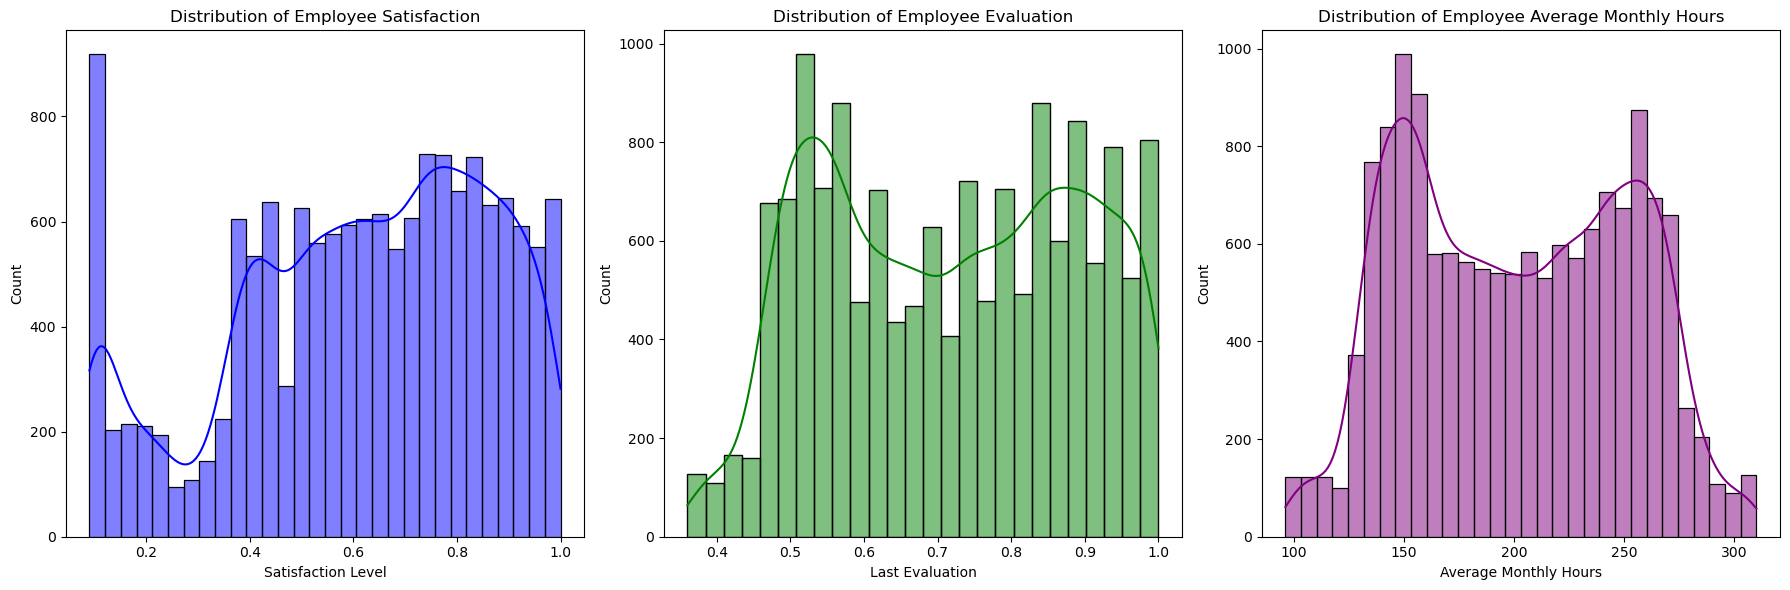

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot distribution for satisfaction_level
sns.histplot(df['satisfaction_level'], kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Employee Satisfaction')
axes[0].set_xlabel('Satisfaction Level')

# Plot distribution for last_evaluation
sns.histplot(df['last_evaluation'], kde=True, color='green', ax=axes[1])
axes[1].set_title('Distribution of Employee Evaluation')
axes[1].set_xlabel('Last Evaluation')

# Plot distribution for average_montly_hours
sns.histplot(df['average_montly_hours'], kde=True, color='purple', ax=axes[2])
axes[2].set_title('Distribution of Employee Average Monthly Hours')
axes[2].set_xlabel('Average Monthly Hours')

plt.tight_layout()
plt.show()

## Conclusions

#### 1. Employee Satisfaction (satisfaction_level):
There is a peak at the lower satisfaction levels (around 0.1–0.2). A significant proportion of employees seem to have lower satisfaction.

#### 2. Employee Evaluation (last_evaluation):
There is a slight peak around 0.5. and 0.8–1.0

A significant number of employees are either average performers or high performers. 
The presence of high-performing employees indicates strong potential, but employees with lower evaluations might require additional training or support.

#### 3. Employee Average Monthly Hours (average_montly_hours):
There are two peaks in the distribution — one around 150–160 hours and another around 250–260 hours.
This suggests some employees work regular hours while others might be overworked. 
The overworked group could experience burnout, affecting overall satisfaction and performance.

#### Overall Insights:
Low satisfaction levels and employees with excessive monthly hours could indicate underlying workplace issues, such as stress, workload imbalance, or inadequate support.

The company should investigate the causes of low satisfaction and implement strategies to improve it, such as recognizing high-performing employees, improving working conditions, and addressing workload imbalances.

## 2.3. Draw the bar plot of the employee project count of both employees who left and stayed in the organization (use column number_project and hue column left), and give your inferences from the plot.


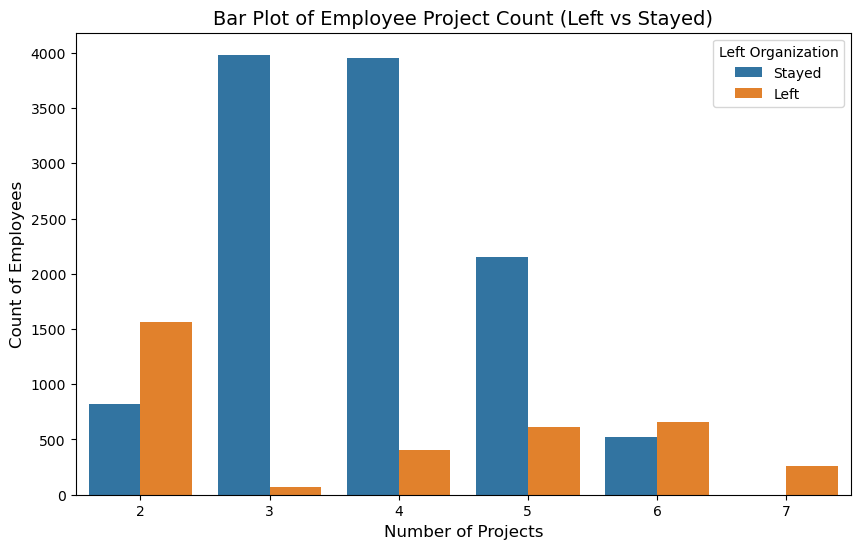

In [18]:
plt.figure(figsize=(10, 6))

sns.barplot(data=df, x='number_project', y='number_project', hue='left', estimator=len, errorbar=None, dodge=True)

plt.title('Bar Plot of Employee Project Count (Left vs Stayed)', fontsize=14)
plt.xlabel('Number of Projects', fontsize=12)
plt.ylabel('Count of Employees', fontsize=12)
plt.legend(title='Left Organization', labels=['Stayed', 'Left'])

plt.show()

## Conclusions:

#### Insights:
-- Employees with very few projects or too many projects are more likely to leave.

-- 3 projects seems to be the ideal workload to keep an employee from leaving.

#### 1. Employees with 2 Projects:
A significant proportion of employees with only 2 projects left the organization.
This suggests that employees with very low workloads might be dissatisfied or underutilized, potentially leading to attrition.
    
#### 2. Employees with 3 Projects:
The majority of employees who worked on 3 projects stayed in the organization.
This indicates that 3 projects could represent an optimal workload, where employees are neither underutilized nor overburdened.

#### 3. Employees with 4-5 Projects:
There is an increase in the proportion of employees leaving as the project count rises to 4 or 5 projects.
This suggests that a higher workload may lead to dissatisfaction or burnout, leading to attrition.
    
#### 4. Employees with 6-7 Projects:
Employees with 6 or more projects have a higher likelihood of leaving the organization.
This is an indicator of excessive workload, which might contribute to stress and dissatisfaction.


## Recommendations:

Balanced workloads: Avoid underutilizing or overburdening employees to reduce attrition.

Take Feedbacks: Understand the challenges faced by employees with very low or very high workloads.

Provide additional resources or incentives to employees handling 4 or more projects.

## 3. Perform clustering of employees who left based on their satisfaction and evaluation.

### 3.1. Choose columns satisfaction_level, last_evaluation, and left.

In [21]:
selected_columns = df[["satisfaction_level","last_evaluation","left"]]
selected_columns.head(10)

,satisfaction_level,last_evaluation,left
0,0.38,0.53,1
1,0.80,0.86,1
2,0.11,0.88,1
3,0.72,0.87,1
4,0.37,0.52,1
5,0.41,0.50,1
6,0.10,0.77,1
7,0.92,0.85,1
8,0.89,1.00,1
9,0.42,0.53,1


## 3.2. Do K-means clustering of employees who left the company into 3 clusters

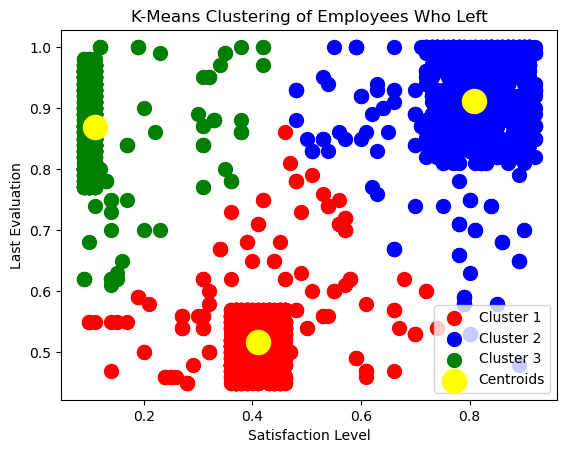

In [23]:
X = selected_columns[selected_columns["left"] == 1][["satisfaction_level", "last_evaluation"]]

model = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_kmeans = model.fit_predict(X)

plt.scatter(X[y_kmeans == 0]["satisfaction_level"], X[y_kmeans == 0]["last_evaluation"], s=100, c='red', label='Cluster 1')
plt.scatter(X[y_kmeans == 1]["satisfaction_level"], X[y_kmeans == 1]["last_evaluation"], s=100, c='blue', label='Cluster 2')
plt.scatter(X[y_kmeans == 2]["satisfaction_level"], X[y_kmeans == 2]["last_evaluation"], s=100, c='green', label='Cluster 3')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=300, c='yellow', label='Centroids')

plt.title('K-Means Clustering of Employees Who Left')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.legend()
plt.show()


## 3.3. Based on the satisfaction and evaluation factors, give your thoughts on the employee clusters.

## Conclusions

#### Cluster 1 (Red): 

Employees are clustered in the lower-left region, with low satisfaction level (around 0.2 to 0.4), and relatively low last evaluation is also (around 0.5). 

This suggests that employees in this group are dissatisfied and had lower performance evaluations, which could indicate that low satisfaction and performance may be the reason for their leaving.

#### Cluster 2 (Blue): 

Employees are clustered in the upper-right area, with higher satisfaction levels (close to 0.8 to 1.0) and also high performance evaluations (around 0.7 and above). 

This suggests that employees in this group are more satisfied and have better evaluations, but they might still leave for other reasons.
                                                                                                                     
#### Cluster 3 (Green): 

Employees are clustered in the top-left region with high evaluations (around 0.9) but lower satisfaction levels (around 0.2 to 0.4). 

This suggest the employee left due to factors other than their performance, such as work environment or personal issues.


## 4. Handle the left Class Imbalance using the SMOTE technique.

### 4.1. Pre-process the data by converting categorical columns to numerical columns by:

#### ■ Separating categorical variables and numeric variables
#### ■ Applying get_dummies() to the categorical variables
#### ■ Combining categorical variables and numeric variables

In [27]:
#check the shape of dataframe

df.shape

(14999, 10)

##### Dataframe has 14999 rows and 10 columns

In [29]:
#check data types of columns 

df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

##### Two columns i.e 'sales' and 'salary' are categorical. So this needs to be converted to numerical columns using get_dummies()

In [31]:
# create dummy variables of categorical columns

sa = pd.get_dummies(df['sales'],prefix='sales',drop_first=True,dtype=int)
df = pd.concat([df,sa],axis=1)

sal = pd.get_dummies(df['salary'],prefix='salary',dtype=int)
df = pd.concat([df,sal],axis=1)

In [32]:
df.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary,...,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
5,0.41,0.50,2,153,3,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
6,0.10,0.77,6,247,4,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
7,0.92,0.85,5,259,5,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
8,0.89,1.00,5,224,5,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
9,0.42,0.53,2,142,3,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0


In [33]:
# Dropping the variables for which dummies are created and creating n new dataframe df1 for it

df1 = df.drop(['sales','salary'], axis=1)

In [34]:
df1

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
14995,0.37,0.48,2,160,3,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
14996,0.37,0.53,2,143,3,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
14997,0.11,0.96,6,280,4,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0


## 4.2. Do the stratified split of the dataset to train and test in the ratio 80:20 with random_state=123

In [36]:
#check value counts for 'left' column 

df1.left.value_counts()

left
0    11428
1     3571
Name: count, dtype: int64

In [37]:
# Separate features and target variable

X = df1.drop(columns=['left'])
y = df1['left']

In [38]:
print(X.shape)
print(y.shape)

(14999, 19)
(14999,)


In [39]:
# Split the dataset into training and testing sets

X_train,X_test,y_train,y_test = train_test_split(X,y ,test_size=0.2,random_state=123,stratify=y)

In [40]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11999, 19)
(3000, 19)
(11999,)
(3000,)


In [41]:
# Standardize the feature variables

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

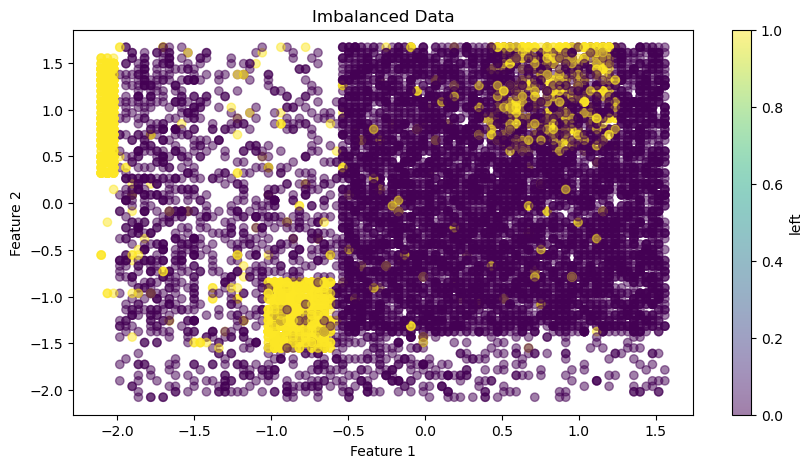

In [42]:
# Scatter plot for the imbalanced data

plt.figure(figsize=(10, 5))
plt.scatter(X_train_sc[:, 0], X_train_sc[:, 1], c=y_train, alpha=0.5, cmap='viridis', marker='o')
plt.title('Imbalanced Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='left')

### 4.3. Upsample the train dataset using the SMOTE technique from the imblearn module.

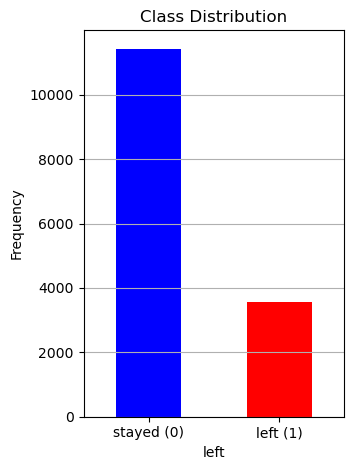

In [44]:
#visualise left class distribution

class_distribution = df1['left'].value_counts()
plt.subplot(1, 2, 1)
class_distribution.plot(kind='bar', color=['blue', 'red'])
plt.title('Class Distribution')
plt.xlabel('left')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['stayed (0)', 'left (1)'], rotation=0)
plt.grid(axis='y')

# Show the plots
plt.tight_layout()
plt.show()

In [45]:
# Apply SMOTE

smote = SMOTE(random_state=123)
X_train_smote, y_train_smote = smote.fit_resample(X_train_sc, y_train)

In [46]:
print(X_train_smote.shape)
print(y_train_smote.shape)

(18284, 19)
(18284,)


Text(0, 0.5, 'Feature 2')

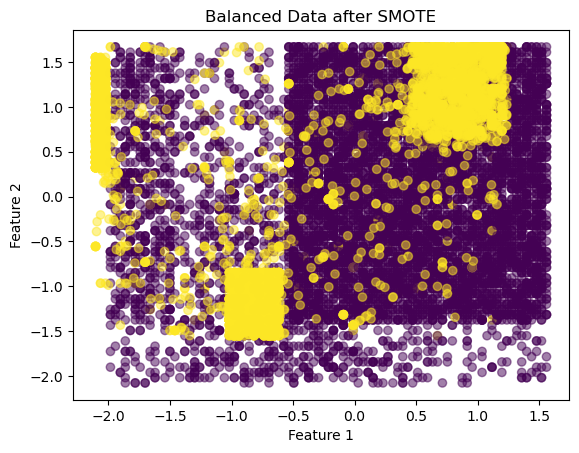

In [47]:
plt.scatter(X_train_smote[:, 0], X_train_smote[:, 1], c=y_train_smote, alpha=0.5, cmap="viridis", marker='o')
plt.title('Balanced Data after SMOTE')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

## 5. Perform 5-fold cross-validation model training and evaluate performance.

### 5.1. Train a logistic regression model, apply a 5-fold CV, and plot the classification report.

In [49]:
log_reg = LogisticRegression(random_state=123)

In [50]:
y_pred_log_reg = cross_val_predict(log_reg, X_train_smote, y_train_smote, cv=5)
print("Logistic Regression Classification Report:")
print(classification_report(y_train_smote, y_pred_log_reg))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.77      9142
           1       0.76      0.81      0.78      9142

    accuracy                           0.78     18284
   macro avg       0.78      0.78      0.78     18284
weighted avg       0.78      0.78      0.78     18284



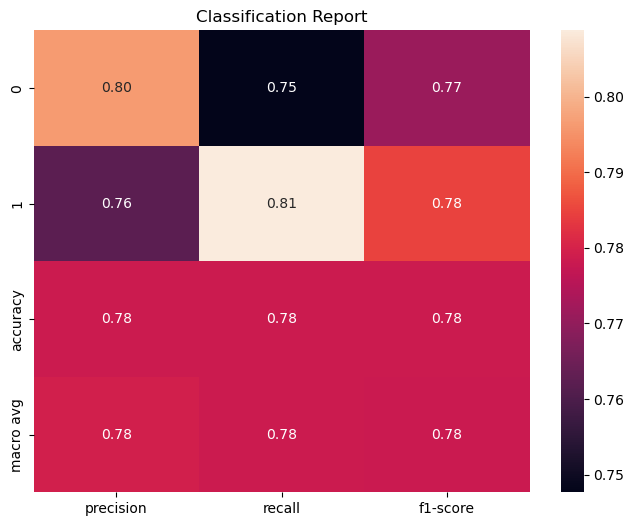

In [51]:
# visualising Classification report

report_dict = classification_report(y_train_smote, y_pred_log_reg, output_dict=True)

# Convert to DataFrame for easier handling
report_df = pd.DataFrame(report_dict).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True,fmt=".2f")
plt.title("Classification Report")
plt.show()

### 5.2. Train a Random Forest Classifier model, apply the 5-fold CV, and plot the classification report.

In [53]:
rf = RandomForestClassifier(random_state = 123)

In [54]:
y_pred_rf = cross_val_predict(rf, X_train_smote, y_train_smote, cv=5)
print("Logistic Regression Classification Report:")
print(classification_report(y_train_smote, y_pred_rf))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9142
           1       1.00      0.98      0.99      9142

    accuracy                           0.99     18284
   macro avg       0.99      0.99      0.99     18284
weighted avg       0.99      0.99      0.99     18284



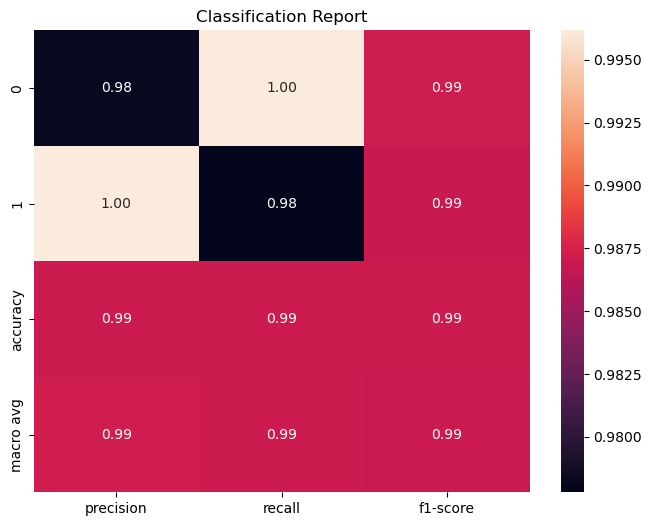

In [55]:
# visualising Classification report

report_dict = classification_report(y_train_smote, y_pred_rf, output_dict=True)

# Convert to DataFrame for easier handling
report_df = pd.DataFrame(report_dict).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True,fmt=".2f")
plt.title("Classification Report")
plt.show()

### 5.3. Train a Gradient Boosting Classifier model, apply the 5-fold CV, and plot the classification report.

In [57]:
gbc = GradientBoostingClassifier(random_state=123)

In [58]:
y_pred_gbc = cross_val_predict(gbc, X_train_smote, y_train_smote, cv=5)
print("Logistic Regression Classification Report:")
print(classification_report(y_train_smote, y_pred_gbc))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      9142
           1       0.98      0.96      0.97      9142

    accuracy                           0.97     18284
   macro avg       0.97      0.97      0.97     18284
weighted avg       0.97      0.97      0.97     18284



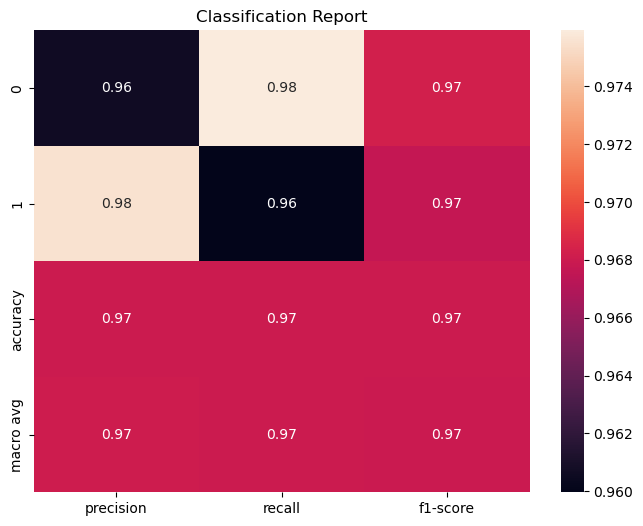

In [59]:
# visualising Classification report

report_dict = classification_report(y_train_smote, y_pred_gbc, output_dict=True)

# Convert to DataFrame for easier handling
report_df = pd.DataFrame(report_dict).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f")
plt.title("Classification Report")
plt.show()

## 6. Identify the best model and justify the evaluation metrics used.

### 6.1. Find the ROC/AUC for each model and plot the ROC curve.

In [61]:
log_reg.fit(X_train_smote, y_train_smote)

LogisticRegression(random_state=123)

In [62]:
rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=123)

In [63]:
gbc.fit(X_train_smote, y_train_smote)

GradientBoostingClassifier(random_state=123)

In [64]:
# predict probabilities
pred_prob_log_reg = log_reg.predict_proba(X_test_sc)
pred_prob2_rf = rf.predict_proba(X_test_sc)
pred_prob3_gbc = gbc.predict_proba(X_test_sc)

In [65]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob_log_reg[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2_rf[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3_gbc[:,1], pos_label=1)


In [66]:
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [67]:
#from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob_log_reg[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2_rf[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob3_gbc[:,1])


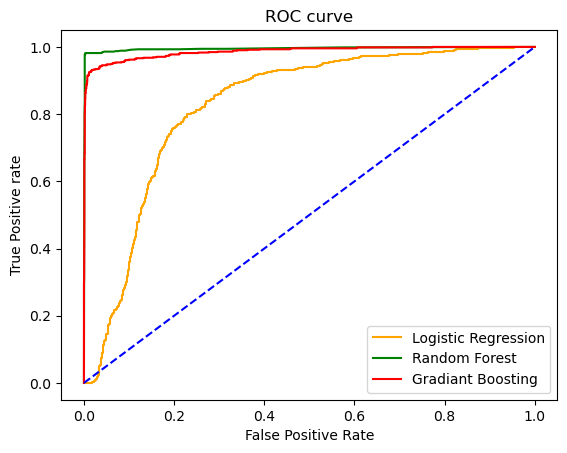

In [68]:
# matplotlib
#import matplotlib.pyplot as plt
#plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1,color='orange',label='Logistic Regression')
plt.plot(fpr2, tpr2,color='green', label='Random Forest')
plt.plot(fpr3, tpr3,color='red', label='Gradiant Boosting')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

## Conclusion 

##### It is clear from the plot that the AUC for the Random Forest ROC curve is higher than that for the Gradiant Boosting and Logistic Regression ROC curve. Therefore, we can say that Random Forest did a better job of classifying the positive class in the dataset.

### 6.2. Find the confusion matrix for each of the models.


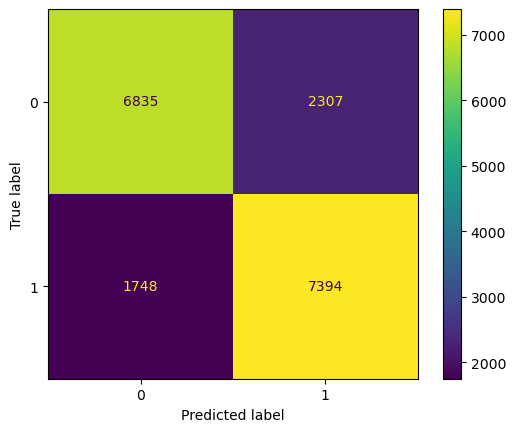

In [71]:
#confusion metrix for logistic regression

ConfusionMatrixDisplay.from_predictions(y_train_smote, y_pred_log_reg)

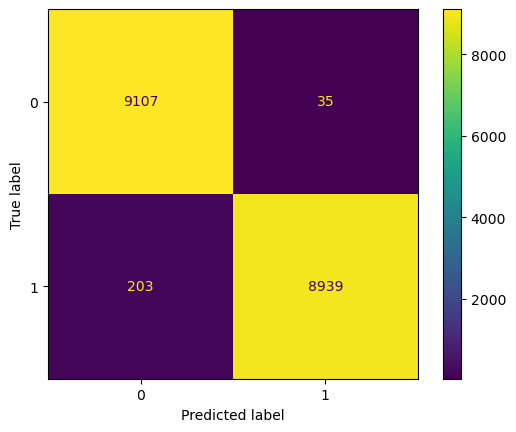

In [72]:
#confusion metrix for random forest

ConfusionMatrixDisplay.from_predictions(y_train_smote, y_pred_rf)

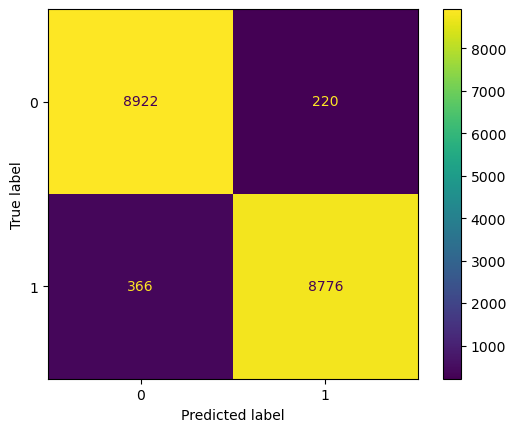

In [73]:
#confusion metrix for gradient boosting

ConfusionMatrixDisplay.from_predictions(y_train_smote, y_pred_gbc)

### 6.3. Explain which metric needs to be used from the confusion matrix: Recall or Precision?

##### Precision: 
Focuses on how many of the predicted positives (i.e., employees predicted to leave) were actually true positives. High precision means fewer false positives (i.e., fewer employees incorrectly predicted to leave).

##### Recall: 
Focuses on how many of the actual positives (i.e., actual employees who left) were correctly identified. High recall means fewer false negatives (i.e., fewer employees who left but were not predicted).

##### For employee turnover, 
where failing to predict an employee leaving can be costly (e.g., missed opportunities for retention), <b>Recall</b> is often more important. This is because the business may want to identify as many employees who are likely to leave as possible (even at the cost of some false positives), in order to take actions such as retention programs or offers.

In the given matrices, <b>Random Forest Model</b> seems to provide a good balance with high precision and recall.

## 7. Suggest various retention strategies for targeted employees.

### 7.1. Using the best model, predict the probability of employee turnover in the test data.


In [77]:
y_pred_rf_test = rf.predict(X_test_sc)
y_pred_prob_rf_test = rf.predict_proba(X_test_sc)

In [78]:
# Determine the class order
class_order = rf.classes_
print("Class order:", class_order)

# Create a DataFrame to display actual and predicted labels with probabilities
results_df = pd.DataFrame({
    'Actual Label': y_test,
    'Predicted Label': y_pred_rf_test,
})

# Add predicted probabilities with correct class names
for i, class_name in enumerate(class_order):
    results_df[f'Predicted Probability {class_name}'] = np.round(y_pred_prob_rf_test[:, i], 2)

# Display the first few rows of the results DataFrame
results_df.head(10)

Class order: [0 1]


,Actual Label,Predicted Label,Predicted Probability 0,Predicted Probability 1
10627,0,0,0.99,0.01
2703,0,0,0.55,0.45
6059,0,0,0.93,0.07
3258,0,0,1.00,0.00
4565,0,0,1.00,0.00
4991,0,0,0.99,0.01
13976,0,0,0.99,0.01
9427,0,0,1.00,0.00
7173,0,0,1.00,0.00
13412,0,0,1.00,0.00


### 7.2. Based on the probability score range below, categorize the employees into four zones and suggest your thoughts on the retention strategies for each zone.

### ■ Safe Zone (Green) (Score < 20%)
### ■ Low-Risk Zone (Yellow) (20% < Score < 60%)
### ■ Medium-Risk Zone (Orange) (60% < Score < 90%)
### ■ High-Risk Zone (Red) (Score > 90%)

In [80]:
# Define a function to categorize into zones based on score
def categorize_zone(prob):
    if prob < 0.2:
        return "Safe"
    elif 0.2 <= prob < 0.6:
        return "Low-Risk"
    elif 0.6 <= prob < 0.9:
        return "Medium-Risk"
    else:
        return "High-Risk"

# Add a "Zone" column to the results DataFrame
results_df['Zone'] = results_df['Predicted Probability 1'].apply(categorize_zone)

# Display the first few rows with the Zone column
results_df.head(20)

# Filter employees by each zone
safe_zone = results_df[results_df["Zone"] == "Safe"]
low_risk_zone = results_df[results_df["Zone"] == "Low-Risk"]
medium_risk_zone = results_df[results_df["Zone"] == "Medium-Risk"]
high_risk_zone = results_df[results_df["Zone"] == "High-Risk"]

# Example: Print the number of employees in each zone
print("Safe Zone:", len(safe_zone))
print("Low-Risk Zone:", len(low_risk_zone))
print("Medium-Risk Zone:", len(medium_risk_zone))
print("High-Risk Zone:", len(high_risk_zone))


Safe Zone: 2199
Low-Risk Zone: 97
Medium-Risk Zone: 52
High-Risk Zone: 652


In [81]:
results_df

,Actual Label,Predicted Label,Predicted Probability 0,Predicted Probability 1,Zone
10627,0,0,0.99,0.01,Safe
2703,0,0,0.55,0.45,Low-Risk
6059,0,0,0.93,0.07,Safe
3258,0,0,1.00,0.00,Safe
4565,0,0,1.00,0.00,Safe
...,...,...,...,...,...
4961,0,0,1.00,0.00,Safe
4557,0,0,0.92,0.08,Safe
6610,0,0,0.97,0.03,Safe
10327,0,0,0.96,0.04,Safe


          Zone  Count
0    High-Risk    652
1     Low-Risk     97
2  Medium-Risk     52
3         Safe   2199


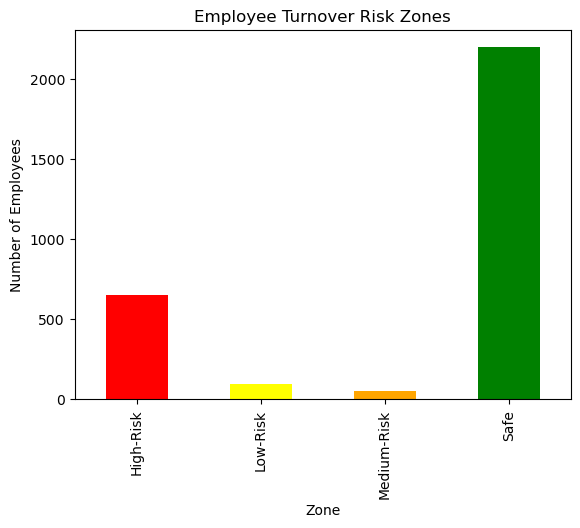

In [82]:
# Summarize probabilities and zones
zone_summary = results_df.groupby('Zone').size().reset_index(name='Count')
print(zone_summary)

zone_summary.plot(kind='bar', x='Zone', y='Count', legend=False, color=['red', 'yellow', 'orange', 'green'])
plt.title("Employee Turnover Risk Zones")
plt.xlabel("Zone")
plt.ylabel("Number of Employees")
plt.show()


## Retention Strategies for Each Zone

#### 1. Safe Zone (Green: Score < 20%)
These employees are the least likely to leave. Strategies should focus on maintaining satisfaction and engagement:

##### Recognition and Rewards: 
Regularly acknowledge their contributions through verbal recognition, bonuses, or awards.

##### Growth Opportunities: 
Provide opportunities for career advancement, such as promotions, skill-building programs, or leadership roles.

##### Work-Life Balance: 
Continue fostering a healthy work-life balance with flexible hours or remote work options.

#### 2. Low-Risk Zone (Yellow: 20% < Score < 60%)
These employees are moderately satisfied but might leave if better opportunities arise. Strategies should proactively address concerns:

##### Stay Interviews: 
Conduct one-on-one meetings to understand their challenges and career aspirations.

##### Professional Development: 
Offer training programs, certifications, or mentorship opportunities to upskill.

##### Competitive Compensation: 
Regularly review and adjust salaries and benefits to remain competitive in the market.

#### 3. Medium-Risk Zone (Orange: 60% < Score < 90%)
These employees are at significant risk of turnover. Retention efforts should focus on resolving dissatisfaction:

##### Customized Plans: 
Identify specific grievances through surveys or feedback and address them individually.

##### Increased Engagement: 
Create initiatives like team-building activities, hackathons, or cross-functional projects.

##### Job Role Alignment: 
Ensure their responsibilities align with their interests and skills to improve job satisfaction.

#### 4. High-Risk Zone (Red: Score > 90%)
These employees are highly likely to leave. Immediate intervention is required:

##### Exit Interviews: 
If resignation is imminent, understand the reasons and learn from their feedback to improve retention for others.

##### Retention Bonuses: 
Offer retention bonuses or promotions for critical employees.

##### Leadership Intervention: 
Have senior leadership personally engage with these employees to rebuild trust and morale.